# Galaxy classification

The goal is to determine the demographics of galaxies with spiral arms, which are correlated with star formation in the discs of low-redshift galaxies, and therefore, contribute to the understanding of star formation in the Local Universe. A large citizen science initiative called Galaxy Zoo 2 (1) has collected human annotations of roughly 300000 images of galaxies from the Sloan Digital Sky Survey (2) with the goal of measuring these demographics. The target of inference is the fraction of galaxies with spiral arms. This notebook shows that prediction-powered inference allows for a decrease in the requisite number of human-annotated galaxies by imputing labels via computer vision.

1. K. W. Willett,  C. J. Lintott,  S. P. Bamford,  K. L. Masters, B. D. Simmons,  K. R. V. Casteels,  E. M. Edmondson,  L. F. Fortson, S. Kaviraj,  W. C. Keel, T. Melvin, R. C. Nichol, M. J. Raddick, K. Schawinski, R. J. Simpson, R. A. Skibba, A. M. Smith, D. Thomas, Galaxy Zoo 2: detailed morphological classifications for 304 122 galaxies from the Sloan Digital Sky Survey. Monthly Notices of the Royal Astronomical Society 435(4), 2835–2860 (2013).
2. D. G. York, J. Adelman, J. E. Anderson Jr, S. F. Anderson, J. Annis, N. A. Bahcall, …, N. Yasuda, The Sloan digital sky survey: Technical summary. The Astronomical Journal 120(3), 1579 (2000).

### Import necessary packages

In [2]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci_tuned, classical_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

### Import the forest data set

Load the data. The data set contains gold-standard deforestation labels (```Y```) and predicted deforestation labels (```Yhat```).

In [3]:
dataset_folder = "../data/"
data = load_dataset(dataset_folder, "galaxies")
Y_total = data["Y"]
Yhat_total = data["Yhat"]

Dataset galaxies not found at location ../data/; downloading now...


Downloading...
From: https://drive.google.com/uc?id=1pDLQesPhbH5fSZW1m4aWC-wnJWnp1rGV
To: /Users/angelopoulos/Code/working/ppi_py/examples/data/galaxies.npz
100%|██████████| 268k/268k [00:00<00:00, 21.5MB/s]


### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [5]:
alpha = 0.05
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(200, 1000, 10).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 100

# True mean (computed on all labels)
true_theta = Y_total.mean()

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```tuned PPI```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [6]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[n:]

        ppi_ci = ppi_mean_ci_tuned(_Y, _Yhat, _Yhat_unlabeled, lhat=1, alpha=alpha)
        ppi_ci_tuned = ppi_mean_ci_tuned(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)

        # Classical interval
        classical_ci = classical_mean_ci(_Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0],
                        "upper": ppi_ci[1],
                        "included": (ppi_ci[0] <= true_theta) & (ppi_ci[1] >= true_theta),
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "tuned PPI",
                        "n": n,
                        "lower": ppi_ci_tuned[0],
                        "upper": ppi_ci_tuned[1],
                        "included": (ppi_ci_tuned[0] <= true_theta) & (ppi_ci_tuned[1] >= true_theta),
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "classical",
                        "n": n,
                        "lower": classical_ci[0],
                        "upper": classical_ci[1],
                        "included": (classical_ci[0] <= true_theta) & (classical_ci[1] >= true_theta),
                        "trial": j
                    }
                ]
            )
        ]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.87it/s]


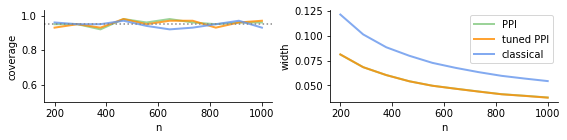

In [7]:
palette = {'tuned PPI' : 'darkorange',
           'PPI' : '#83C980',
           'classical' : 'cornflowerblue'}
linewidth=2

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,2), sharex=True)
cvg_ax = axs[0]
sz_ax = axs[1]
sns.lineplot(ax=cvg_ax, data=df, x="n", y="included", linewidth=linewidth, errorbar=None, hue="method", legend=False, palette=palette, alpha=0.8)
sns.lineplot(ax=sz_ax, data=df, x="n", y="width", linewidth=linewidth, errorbar=None, hue="method", legend=True, palette=palette, alpha=0.8)
cvg_ax.set_ylabel("coverage")
cvg_ax.set_ylim([0.5,1.03])
cvg_ax.axhline(y=1-alpha, color="#888888", linestyle='dotted')
cvg_ax.set_xlabel('n')
sz_ax.set_ylabel('width')
sz_ax.legend_.set_title(None)
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs('./plots',exist_ok=True)
plt.savefig('./plots/tuned-PPI-galaxies.pdf')